In [ ]:
#default_exp augment.spectrogram

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from fastcore.transform import Transform
from fastai2.data.all import *
from fastai2_audio.core.all import *
from fastai2_audio.augment.signal import AudioPadType, CropSignal
from fastai2.vision.augment import RandTransform

In [ ]:
from setup_example import *

In [ ]:
# export
import librosa

# Spectrogram Transforms
> Transforms that operate on audio Spectrograms

##  Time Cropping

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong><br> 
   1. In spectrogram when we pad with mean value we mess up normalization by altering std dev, how can we use fill values that dont mess things up<br></div>


In [ ]:
#export
class CropTime(Transform):
    '''Random crops full spectrogram to be length specified in ms by crop_duration'''
    def __init__(self, duration, pad_mode=AudioPadType.Zeros):
        store_attr(self, "duration, pad_mode")
    def encodes(self, sg:AudioSpectrogram)->AudioSpectrogram:
        sr, hop = sg.sr, sg.hop_length
        w_crop = int((sr*self.duration)/(1000*hop))+1
        w_sg   = sg.shape[-1]
        if     w_sg == w_crop: sg_crop = sg
        elif   w_sg <  w_crop: sg_crop = _tfm_pad_spectro(sg, w_crop, pad_mode=self.pad_mode)
        else:
            crop_start = random.randint(0, int(w_sg - w_crop)) 
            sg_crop = sg[:,:,crop_start:crop_start+w_crop]
            sg_crop.sample_start = int(crop_start*hop)
            sg_crop.sample_end   = sg_crop.sample_start + int(self.duration*sr)
        sg.data = sg_crop
        return sg

In [ ]:
#export
def _tfm_pad_spectro(sg, width, pad_mode=AudioPadType.Zeros):
    '''Pad spectrogram to specified width, using specified pad mode'''
    c,y,x = sg.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros_after"]:
        padded = torch.zeros((c,y,width))
        start = random.randint(0, width-x) if pad_m == "zeros" else 0
        padded[:,:,start:start+x] = sg.data
        return padded
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sg.repeat(1,1,repeats)[:,:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros_after', or 'repeat'")

In [ ]:
audio_orig = GenExample.audio_sc()

In [ ]:
crop_1000ms = CropTime(1000)
crop_2000ms = CropTime(2000)
crop_5000ms = CropTime(5000)
print(f"Audio is {audio_orig.duration} seconds")

Audio is 3.64 seconds


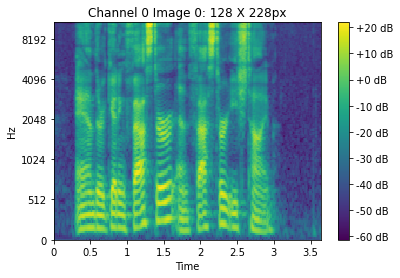

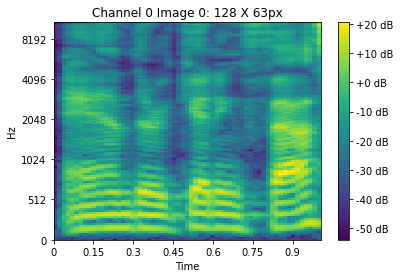

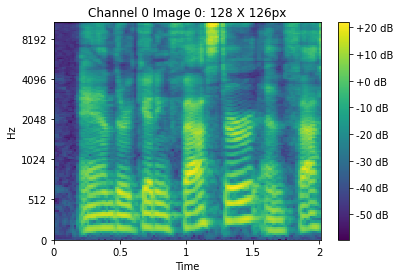

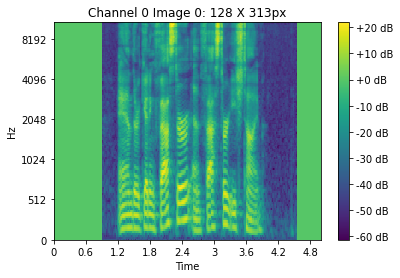

In [ ]:
orig_settings = dict(GenExample.sg_sc().settings)
inp, out1 = show_transform(crop_1000ms, GenExample.sg_sc, show=None)
inp, out2 = show_transform(crop_2000ms, GenExample.sg_sc, show=None)
inp, out5 = show_transform(crop_5000ms, GenExample.sg_sc, show=None)
for spec in [inp, out1, out2, out5]:
    spec.show()

<div class = "alert alert-block alert-info"><strong>Note:</strong><br> 
    Because a spectrograms duration is dependent on rounding (samples/hop_length usually has a remainder that is padded up to an extra pixel), we cant use exact durations, so we must test_close instead of test_eq. This could be fixed by storing the AudioTensors duration when the sg is generated, and also updating the duration manually anytime a Transform occurs that affects the size time axis (x-axis)
</div>


In [ ]:
inp.duration, out1.duration, out5.duration

(3.64, 1.0, 5.0)

In [ ]:
settings_match = [orig_settings[key] == out1.settings[key] for key in orig_settings.keys() if key != "transformer"]
assert False not in settings_match
test_close(out1.width, int((1/inp.duration)*inp.width), eps=1.01)
test_close(out2.width, int((2/inp.duration)*inp.width), eps=1.01)
test_close(out5.width, int((5/inp.duration)*inp.width), eps=1.01)

In [ ]:
# test AudioToSpec->CropTime and CropSignal->AudioToSpec will result in same size images
oa = OpenAudio(ex_files)
crop_dur = random.randint(1000,5000)
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)
pipe_cropsig  = Pipeline([oa, DBMelSpec(hop_length=128), CropTime(crop_dur)])
pipe_cropspec = Pipeline([oa, CropSignal(crop_dur), DBMelSpec(hop_length=128), ])
for i in range(4):
    test_eq(pipe_cropsig(i).width, pipe_cropspec(i).width)

In [ ]:
# test pad_mode zeros-after by verifying sg ends with zeros and begins with non-zeros
sg_orig = GenExample.sg_sc()
crop_5000ms = CropTime(5000, pad_mode=AudioPadType.Zeros_After)
crop_5000ms(sg_orig)
test_eq(sg_orig[:,:,-1], torch.zeros_like(sg_orig)[:,:,-1])
test_ne(sg_orig[:,:,0], torch.zeros_like(sg_orig)[:,:,-1])
test_eq(sg_orig.duration, 5)

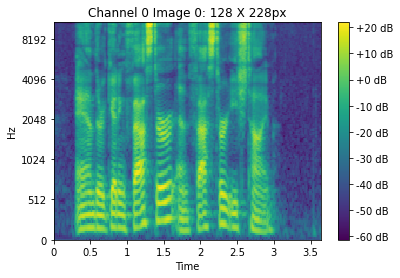

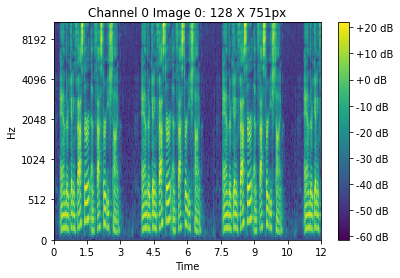

In [ ]:
# test pad_mode repeat by making sure that columns are equal at the appropriate offsets
crop_12000ms_repeat = CropTime(12000, pad_mode=AudioPadType.Repeat)
inp,out = show_transform(crop_12000ms_repeat, GenExample.sg_sc, show=True)
for i in range(inp.width):
    test_eq(out[:,:,i], out[:,:,i+inp.width])
    test_eq(out[:,:,i], out[:,:,i+2*inp.width])

In [ ]:
# test bad pad_mode doesnt fail silently, correct is 'zeros_after'
test_fail(CropTime(12000, pad_mode="zerosafter"))

In [ ]:
out1.shape, out2.shape, out5.shape

(torch.Size([1, 128, 63]),
 torch.Size([1, 128, 126]),
 torch.Size([1, 128, 313]))

In [ ]:
# demonstrate on multichannel audio, (change "show=None" to "show=True" to see)
inp,out = show_transform(crop_1000ms, GenExample.sg_mc, show=False)

#### CropTime Timing Tests

In [ ]:
sg_orig = GenExample.sg_sc()

In [ ]:
%%time
#1s zero-padded crop
out = crop_1000ms(sg_orig)

CPU times: user 136 µs, sys: 14 µs, total: 150 µs
Wall time: 152 µs


In [ ]:
%%time
#5s zero-padded crop
out = crop_5000ms(sg_orig)

CPU times: user 517 µs, sys: 0 ns, total: 517 µs
Wall time: 245 µs


In [ ]:
%%time
#12s repeat-padded crop
out = crop_12000ms_repeat(sg_orig)

CPU times: user 933 µs, sys: 96 µs, total: 1.03 ms
Wall time: 348 µs


<div class = "alert alert-block alert-info"> If we wanted to we could make a class for these transforms that keeps the masked portion as state so that we could write a decodes method to go back to the original</div>


## Time and Frequency Masking (SpecAugment)

In [ ]:
#export
class MaskFreq(Transform):
    '''Google SpecAugment frequency masking from https://arxiv.org/abs/1904.08779.'''
    def __init__(self, num_masks=1, size=20, start=None, val=None, **kwargs):
        store_attr(self, "num_masks,size,start,val")
    def encodes(self, sg:AudioSpectrogram)->AudioSpectrogram:
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None]
        mask_val = ifnone(self.val, channel_mean)
        c, y, x = sg.shape
        # Position of the first mask
        start = ifnone(self.start, random.randint(0, y-self.size))
        for _ in range(self.num_masks):
            mask = torch.ones(self.size, x) * mask_val    
            if not 0 <= start <= y-self.size:
                raise ValueError(f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[:,start:start+self.size,:] = mask
            # Setting start position for next mask
            start = random.randint(0, y-self.size) 
        return sg

<div class = "alert alert-block alert-warning"> Passing around the settings manually is already fairly clunky, but is especially bad when we have to do it twice when MaskTime hands off to MaskFrequency. We should maybe make a copy of the AudioSpectrogram and then alter the tensor for it's sg rather than cloning out the sg and then building a new object at the end. Or just keep a reference to the parent tensor and pass that along, and have getattr recur looking for settings of the parents</div>


In [ ]:
#export
class MaskTime(Transform):
    '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
    def __init__(self, num_masks=1, size=20, start=None, val=None, **kwargs):
        store_attr(self, "num_masks,size,start,val,kwargs")
    def encodes(self, sg:AudioSpectrogram)->AudioSpectrogram:
        sg.data = torch.einsum('...ij->...ji', sg)
        sg.data = MaskFreq(self.num_masks, self.size, self.start, self.val, **self.kwargs)(sg)
        sg.data = torch.einsum('...ij->...ji', sg)
        return sg

In [ ]:
sg_orig = GenExample.sg_sc()

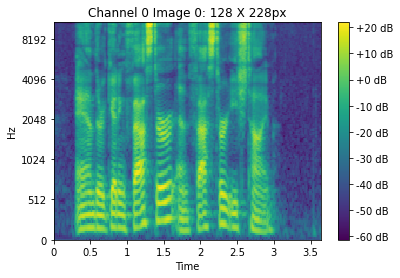

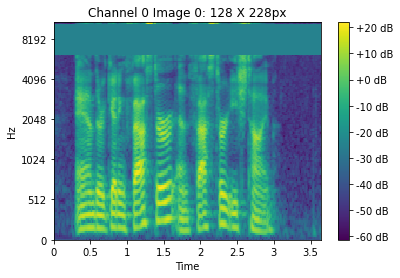

In [ ]:
inp,out = show_transform(MaskFreq(), GenExample.sg_sc)

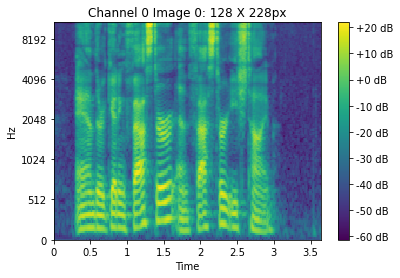

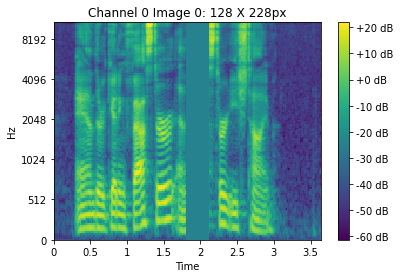

In [ ]:
inp,out = show_transform(MaskTime(), GenExample.sg_sc)

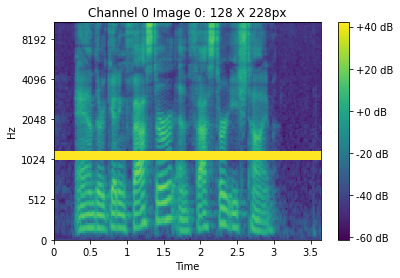

In [ ]:
# create a random frequency mask and test that it is being correctly applied
size, start, val = [random.randint(1, 50) for i in range(3)]
freq_mask_test = MaskFreq(size=size, start=start, val=val)
inp,out = show_transform(freq_mask_test, GenExample.sg_sc, show=None)
out.show()
test_eq(out[:,start:start+size,:], val*torch.ones_like(inp)[:,start:start+size,:])

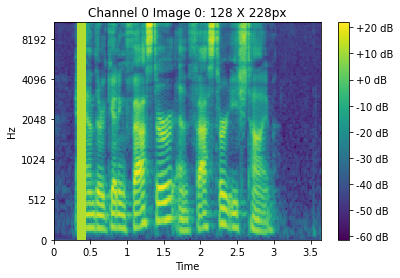

In [ ]:
# create a random time mask and test that it is being correctly applied
size, start, val = [random.randint(1, 50) for i in range(3)]
time_mask_test = MaskTime(size=size, start=start, val=val)
inp,out = show_transform(time_mask_test, GenExample.sg_sc, show=None)
out.show()
test_eq(out[:,:,start:start+size], val*torch.ones_like(inp)[:,:,start:start+size])

In [ ]:
# demonstrate on multichannel audio, (change "show=None" to "show=True" to see)
inp,out = show_transform(MaskFreq(size=40), GenExample.sg_mc, show=None)

#### SpecAugment Timing Tests

In [ ]:
sg_orig = GenExample.sg_sc()
freq_mask = MaskFreq()
time_mask = MaskTime()

In [ ]:
%%time
out = freq_mask(sg_orig)

CPU times: user 2.8 ms, sys: 159 µs, total: 2.96 ms
Wall time: 461 µs


In [ ]:
sg_orig = GenExample.sg_sc()

In [ ]:
%%time
# time masking ~90µs slower because we transpose, delegate to MaskFreq, and transpose back, we could
# fix this at the expense of a bit more code 
out = time_mask(sg_orig)

CPU times: user 3.26 ms, sys: 182 µs, total: 3.44 ms
Wall time: 539 µs


In [ ]:
sg_mc = GenExample.sg_mc()

In [ ]:
%%time
out = freq_mask(sg_mc)

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 440 µs


## Spectrogram Rolling

In [ ]:
#export
class SGRoll(Transform):
    '''Shifts spectrogram along x-axis wrapping around to other side'''
    def __init__(self, max_shift_pct=0.5, direction=0, **kwargs):
        if int(direction) not in [-1, 0, 1]: 
            raise ValueError("Direction must be -1(left) 0(bidirectional) or 1(right)")
        store_attr(self, "max_shift_pct,direction")
            
    def encodes(self, sg:AudioSpectrogram)->AudioSpectrogram:
        direction = random.choice([-1, 1]) if self.direction == 0 else self.direction
        w = sg.shape[-1]
        roll_by = int(w*random.random()*self.max_shift_pct*direction)
        sg.data = sg.roll(roll_by, dims=-1)
        return sg

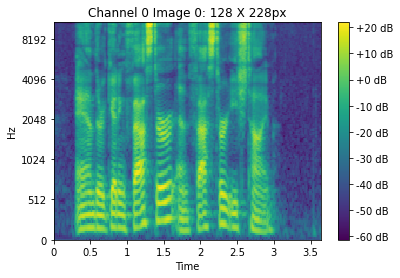

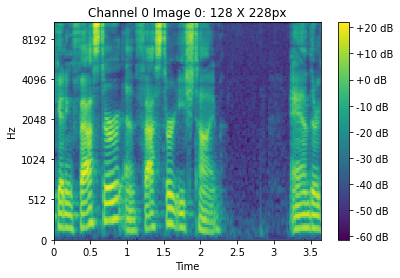

In [ ]:
inp,out = show_transform(SGRoll(), GenExample.sg_sc)

In [ ]:
# demonstrate on multichannel audio, (change "show=None" to "show=True" to see)
inp,out = show_transform(SGRoll(), GenExample.sg_mc, show=None)

#### SGRollTiming Tests

In [ ]:
sg_orig = GenExample.sg_sc()
sg_multi = GenExample.sg_mc()
roller = SGRoll()

In [ ]:
%%time
out = roller(sg_orig)

CPU times: user 4.28 ms, sys: 208 µs, total: 4.49 ms
Wall time: 719 µs


In [ ]:
%%time
out = roller(sg_multi)

CPU times: user 984 µs, sys: 48 µs, total: 1.03 ms
Wall time: 822 µs


## Delta/Accelerate 

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> Test delta as part of a pipeline to make sure SpecAugment/roll/interpolate...etc are working on multichannel</div>


In [ ]:
#export
def _torchdelta(sg:AudioSpectrogram, order=1, width=9):
    '''Converts to numpy, takes delta and converts back to torch, needs torchification'''
    if(sg.shape[1] < width): 
        raise ValueError(f'''Delta not possible with current settings, inputs must be wider than 
        {width} columns, try setting max_to_pad to a larger value to ensure a minimum width''')
    return AudioSpectrogram(torch.from_numpy(librosa.feature.delta(sg.numpy(), order=order, width=width)))

In [ ]:
#export
class Delta(Transform):
    def __init__(self, width=9):
        self.td = partial(_torchdelta, width=width)
        
    def encodes(self, sg:AudioSpectrogram)->AudioSpectrogram:
        new_channels = [torch.stack([c, self.td(c, order=1), self.td(c, order=2)]) for c in sg]
        sg.data = torch.cat(new_channels, dim=0)
        return sg

In [ ]:
delta = Delta()

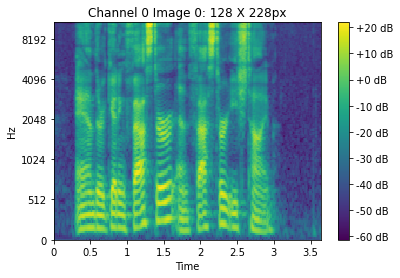

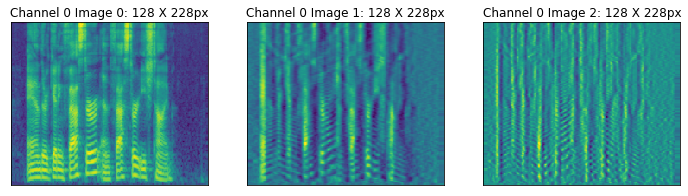

In [ ]:
inp, out = show_transform(delta, GenExample.sg_sc)
#nchannels for a spectrogram is how many channels its original audio had
test_eq(out.nchannels, inp.nchannels)
test_eq(out.shape[1:], inp.shape[1:])
test_ne(out[0],out[1])

In [ ]:
# demonstrate delta on multichannel audio, (change "show=None" to "show=True" to see)
inp,out = show_transform(delta, GenExample.sg_mc, show=False)

#### Delta Timing Tests

In [ ]:
sg_orig = GenExample.sg_sc()
sg_mc = GenExample.sg_mc()

In [ ]:
%%time
out = delta(sg_orig)

CPU times: user 7.06 ms, sys: 0 ns, total: 7.06 ms
Wall time: 1.72 ms


In [ ]:
%%time
out = delta(sg_mc)

CPU times: user 24.7 ms, sys: 32 µs, total: 24.7 ms
Wall time: 4.56 ms


## Image resizing

<div class = "alert alert-block alert-info"> This should probably be refactored to use visions size transform since it already exists</div>


In [ ]:
#export
class TfmResize(Transform):
    '''Temporary fix to allow image resizing transform'''
    def __init__(self, size, interp_mode="bilinear", **kwargs):
        store_attr(self, "size,interp_mode")
    def encodes(self, sg:AudioSpectrogram)->AudioSpectrogram:
        if isinstance(self.size, int): self.size = (self.size, self.size)
        c,y,x = sg.shape
        sg.data = F.interpolate(sg.unsqueeze(0), size=self.size, mode=self.interp_mode, align_corners=False).squeeze(0)
        return sg

In [ ]:
# Test when size is an int
size = 224
resize_int = TfmResize(size)
inp, out = show_transform(resize_int, GenExample.sg_sc, show=None)
print("Original Shape: ", inp.shape)
print("Resized Shape :" , out.shape)
test_eq(out.shape[1:], torch.Size([size,size]))

Original Shape:  torch.Size([1, 128, 228])
Resized Shape : torch.Size([1, 224, 224])


In [ ]:
# Test when size is a tuple with unequal values
size_tup=(124,581)
resize_tup = TfmResize(size_tup)
inp, out = show_transform(resize_tup, GenExample.sg_sc, show=None)
print("Original Shape: ", inp.shape)
print("Resized Shape :" , out.shape)
test_eq(out.shape[1:], torch.Size(size_tup))

Original Shape:  torch.Size([1, 128, 228])
Resized Shape : torch.Size([1, 124, 581])


In [ ]:
# demonstrate resizing on multichannel sg, (change "show=None" to "show=True" to see)
resizer = TfmResize((200,100))
inp,out = show_transform(resizer, GenExample.sg_mc, show=None)
print("Original Shape: ", inp.shape)
print("Resized Shape :" , out.shape)

Original Shape:  torch.Size([3, 128, 211])
Resized Shape : torch.Size([3, 200, 100])


#### Resize Timing Tests

In [ ]:
resizer = TfmResize(224)
sg_orig = GenExample.sg_sc()
sg_mc = GenExample.sg_mc()

In [ ]:
%%time
out = resizer(sg_orig)

CPU times: user 0 ns, sys: 923 µs, total: 923 µs
Wall time: 485 µs


In [ ]:
%%time
out = resizer(sg_mc)

CPU times: user 3.13 ms, sys: 133 µs, total: 3.26 ms
Wall time: 820 µs


## Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()